#### Imports And Data

In [1]:
 # Google Colab specific code
from google.colab import files, drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab\ Notebooks/python2_project/

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/python2_project


In [2]:
import os

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision.models import resnet18

In [3]:
from source.utils import fetch_image_paths_and_labels
from source.utils import display_images, load_image
from source.data_utils import construct_loader

In [19]:
%cd /content

/content


#### Google Colab specific code
Upload images from Kaggle

In [4]:
# Upload the Kaggle API token (kaggle.json) file
uploaded = files.upload()

# Move the uploaded file to the required directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [5]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
100% 3.74G/3.75G [00:45<00:00, 87.0MB/s]
100% 3.75G/3.75G [00:45<00:00, 89.0MB/s]


In [6]:
import zipfile

# Unzip the dataset
with zipfile.ZipFile('140k-real-and-fake-faces.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

#### Load And Process Data

In [7]:
# Define the directory containing the images
image_dir = '/content/real_vs_fake/real-vs-fake/'

train_paths, train_labels = fetch_image_paths_and_labels(image_dir, 'train')
val_paths, val_labels = fetch_image_paths_and_labels(image_dir, 'valid')
test_paths, test_labels = fetch_image_paths_and_labels(image_dir, 'test')

In [8]:
# Apply transformations and convert to DataLoader format for train and test data
trainloader = construct_loader(train_paths, train_labels, train=True)
validloader = construct_loader(val_paths, val_labels, train=False)
testloader = construct_loader(test_paths, test_labels, train=False)

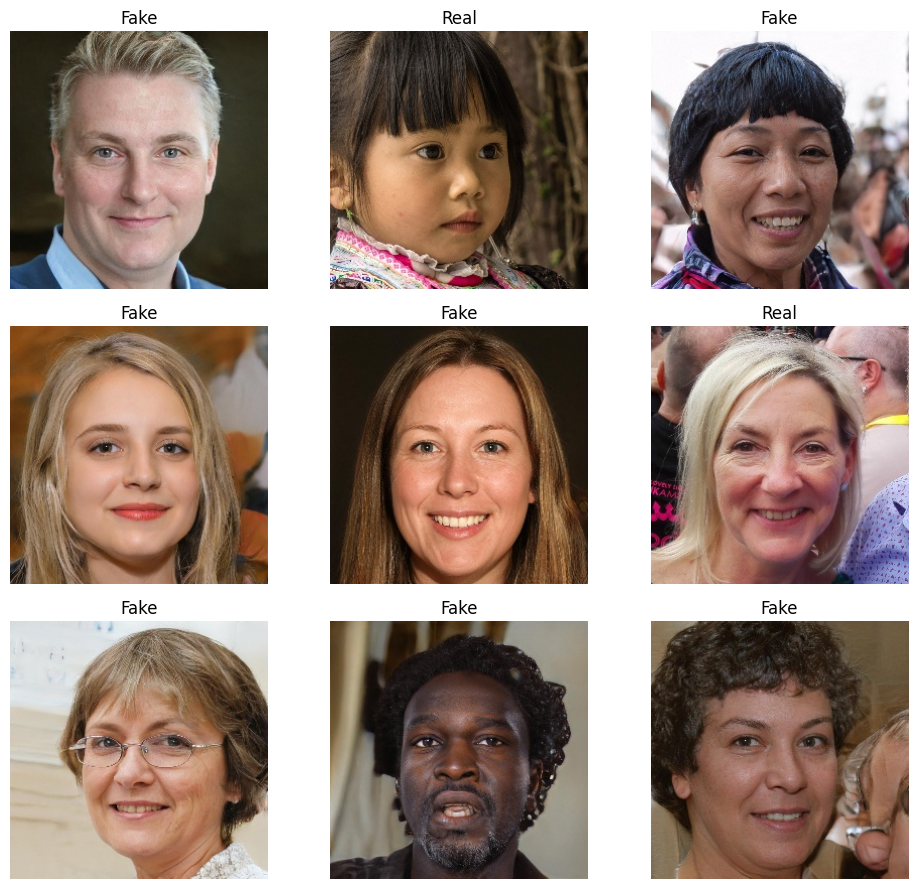

In [41]:
display_images(train_paths[:9], train_labels[:9])

#### Model Setup And Training

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
def create_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)

create_dir("files")
checkpoint_path = "files/checkpoint.pth"

In [25]:
num_classes=2
model = resnet18()
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [37]:
# Function to evaluate the model
def evaluate_model(model, test_loader, criterion, device='cuda'):
    model.eval()  # Set the model to evaluation mode
    correct, total, running_loss = 0, 0, 0.0
    misclassified_images = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            misclassified_images_batch = [
                (img_path, label.item()) for img_path, label, pred in zip(
                    testloader.dataset.image_paths, labels, predicted
                    ) if label != pred]
            misclassified_images.extend(misclassified_images_batch)

    test_accuracy = correct / total
    test_loss = running_loss / len(test_loader.dataset)
    return test_accuracy, test_loss, misclassified_images

In [14]:
# Function to train the model and evaluate on validation data
def train_model(
    model, train_loader, test_loader,
    criterion, optimizer, num_epochs=10,
    device='cuda'):
    # Move the model to the device
    model = model.to(device)
    best_valid_loss = float('inf')

    for epoch in range(num_epochs):
        # Training phase
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc_train = correct_train / total_train
        print(f'Epoch [{epoch+1}/{num_epochs}], \
          Train Loss: {epoch_loss:.4f}, \
          Train Accuracy: {epoch_acc_train:.4f}')

        # Evaluation phase
        validation_accuracy, validation_loss, _ = evaluate_model(
            model, test_loader, criterion, device)
        print(f'Epoch [{epoch+1}/{num_epochs}], \
          Validation Loss: {validation_loss:.4f}, \
          Validation Accuracy: {validation_accuracy:.4f}')

        # Save model checkpoint if validation loss improves
        if validation_loss < best_valid_loss:
            best_valid_loss = validation_loss
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Saving model checkpoint at epoch {epoch+1}')

In [15]:
train_model(model, trainloader, validloader, loss_fn, optimizer)

Epoch [1/10],           Train Loss: 0.5775,           Train Accuracy: 0.6884


AttributeError: 'CustomDataset' object has no attribute 'imgs'

#### Model Evaluation

In [67]:
# Can be used in API
def predict_image_class(model, image_path, device):
    image = load_image(image_path)
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()

In [27]:
# Code for running evaluation with latest trained model

# Load model checkpoins
model.load_state_dict(torch.load(checkpoint_path))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [38]:
# Run evaluation on all test data
test_accuracy, test_loss, misclassified_images = evaluate_model(
    model, testloader, loss_fn, device)


In [39]:
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9664


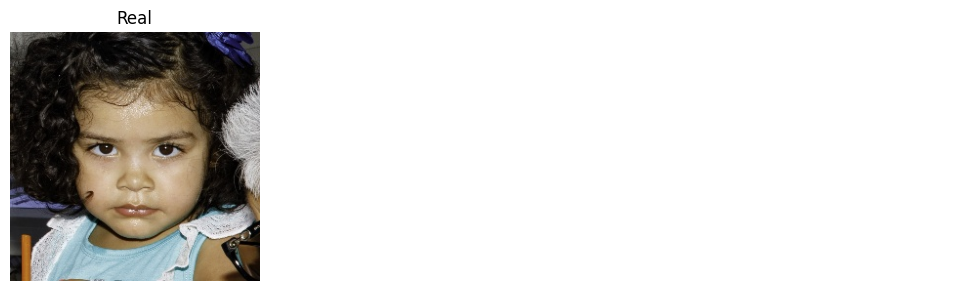

In [64]:
display_images((misclassified_images[0][0],), (misclassified_images[0][1], 1))